In [2]:
import pandas as pd
from prophet import Prophet

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [4]:
m = Prophet()
m.fit(df)

14:48:24 - cmdstanpy - INFO - Chain [1] start processing
14:48:25 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.204239,7.471357,8.995710
3266,2017-01-16,8.529231,7.836013,9.299065
3267,2017-01-17,8.316611,7.589625,9.039008
3268,2017-01-18,8.149244,7.424563,8.901675
3269,2017-01-19,8.161142,7.411782,8.887166


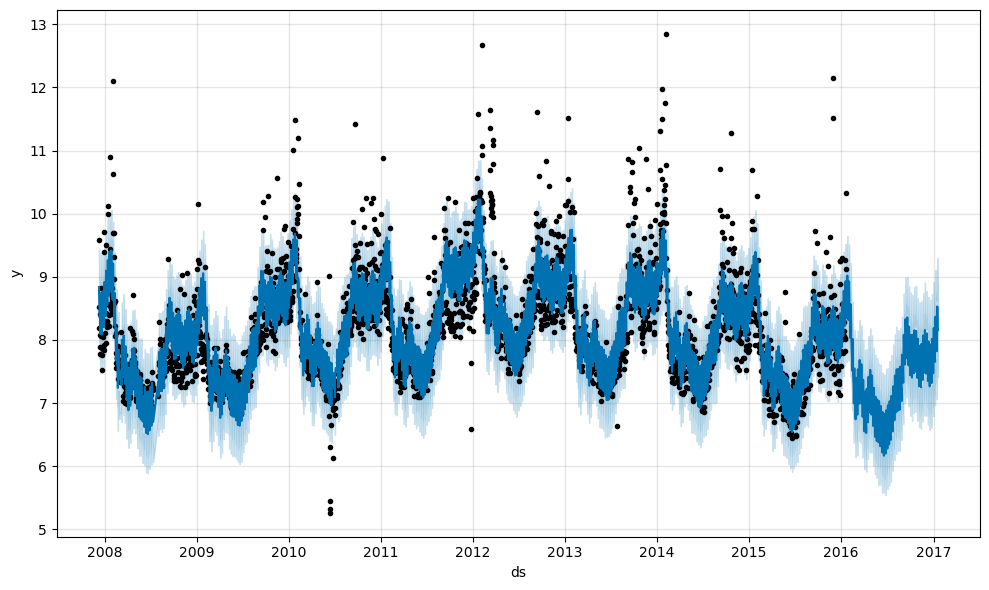

In [7]:
fig1 = m.plot(forecast)

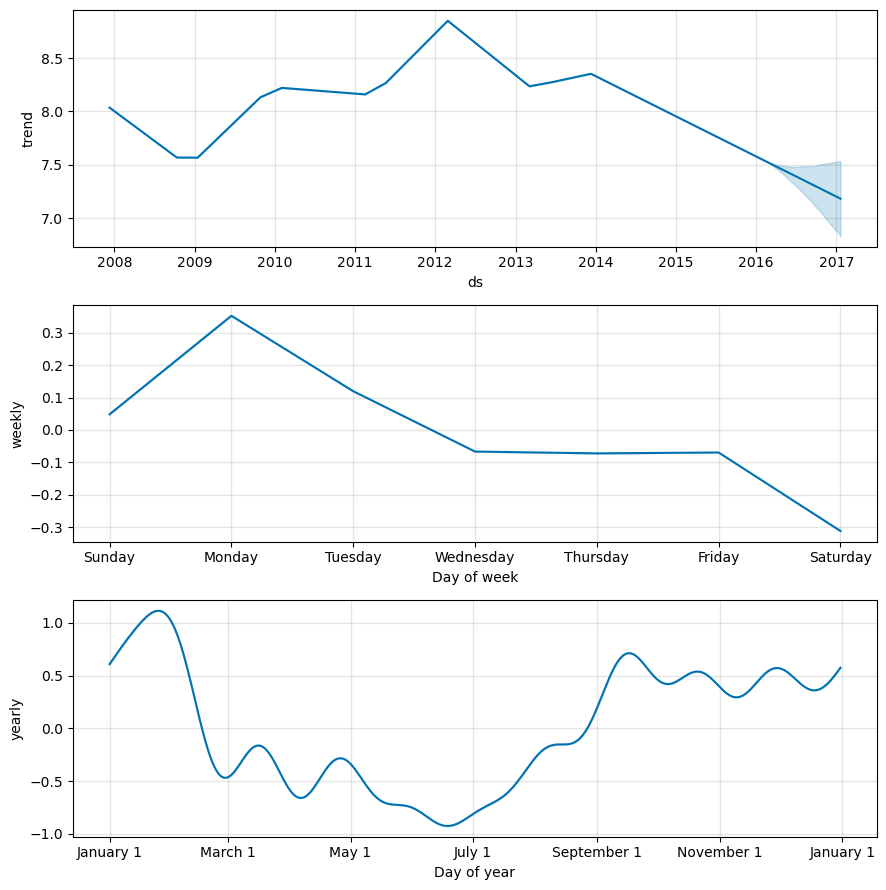

In [8]:
fig2 = m.plot_components(forecast)

In [9]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [10]:
plot_components_plotly(m, forecast)

In [20]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

class AvailabilityAnalyzer:
    def __init__(self):
        self.prophet_model = None
        self.lstm_model = None
        self.scaler = StandardScaler()
    
    def prepare_data(self, df):
        df['Date'] = pd.to_datetime(df['Date'])
        
        df['Impact_Score'] = df['Availability DownTime Duration in hours'] * df['Count of Customers Affected']
        
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['HourOfDay'] = df['Date'].dt.hour
        
        return df
    
    def analyze_patterns(self, df):

        insights = {
            'total_downtime': df['Availability DownTime Duration in hours'].sum(),
            'total_affected': df['Count of Customers Affected'].sum(),
            'avg_duration': df['Availability DownTime Duration in hours'].mean(),
            'worst_day': df.loc[df['Impact_Score'].idxmax()].to_dict(),
            'most_affected_region': df['Regions Affected'].mode().iloc[0],
            'daily_pattern': df.groupby('DayOfWeek')['Availability DownTime Duration in hours'].mean().to_dict(),
            'hourly_pattern': df.groupby('HourOfDay')['Availability DownTime Duration in hours'].mean().to_dict()
        }
        
        return insights
    
    def train_prophet(self, df):

        prophet_df = df[['Date', 'Availability DownTime Duration in hours']].copy()
        prophet_df.columns = ['ds', 'y']
        
        self.prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        self.prophet_model.fit(prophet_df)
        
    def train_lstm(self, df, sequence_length=10):

        data = df['Availability DownTime Duration in hours'].values
        scaled_data = self.scaler.fit_transform(data.reshape(-1, 1))
        
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:(i + sequence_length)])
            y.append(scaled_data[i + sequence_length])
        
        X = np.array(X)
        y = np.array(y)
        
        self.lstm_model = tf.keras.Sequential([
            tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
            tf.keras.layers.Dense(1)
        ])
        
        self.lstm_model.compile(optimizer='adam', loss='mse')
        self.lstm_model.fit(X, y, epochs=100, batch_size=32, verbose=0)
    
    def predict_future(self, days=30):

        future_dates = self.prophet_model.make_future_dataframe(periods=days)
        prophet_forecast = self.prophet_model.predict(future_dates)
        
        return prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    def optimize_outreach(self, df, lead_conversion_data):

        merged_data = pd.merge(df, lead_conversion_data, on='Date', how='inner')
        

        optimal_times = merged_data.groupby(['DayOfWeek', 'HourOfDay']).agg({
            'Availability DownTime Duration in hours': 'mean',
            'Conversion_Rate': 'mean'
        }).reset_index()
    
        optimal_times['Score'] = (
            (1 - optimal_times['Availability DownTime Duration in hours'].rank(pct=True)) * 0.4 +
            optimal_times['Conversion_Rate'].rank(pct=True) * 0.6
        )
        
        return optimal_times.sort_values('Score', ascending=False)
    
    def generate_report(self, df, insights, optimal_times):

        report = {
            'insights': insights,
            'best_outreach_times': optimal_times.head(5).to_dict('records'),
            'recommendations': self._generate_recommendations(insights, optimal_times)
        }
        
        return report
    
    def _generate_recommendations(self, insights, optimal_times):

        recommendations = [
            f"Best day for outreach: {optimal_times.iloc[0]['DayOfWeek']}",
            f"Best hour for outreach: {optimal_times.iloc[0]['HourOfDay']}:00",
            f"Avoid outreach during peak downtime hours: {insights['hourly_pattern'].max()}",
            f"Focus on {insights['most_affected_region']} region for immediate impact"
        ]
        
        return recommendations

In [21]:
analyzer = AvailabilityAnalyzer()
df = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/AvailabilityData.csv',sep="\t")
df.columns

Index(['Date', 'Availability DownTime Duration in hours',
       'Count of Customers Affected', 'Regions Affected'],
      dtype='object')

In [22]:
df = analyzer.prepare_data(df)

In [23]:
insights = analyzer.analyze_patterns(df)
analyzer.train_prophet(df)
analyzer.train_lstm(df)

14:50:29 - cmdstanpy - INFO - Chain [1] start processing
14:50:29 - cmdstanpy - INFO - Chain [1] done processing
/Users/aryamantepal/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
lead_conversion_data = pd.read_csv('lead_conversion_data.csv')
optimal_times = analyzer.optimize_outreach(df, lead_conversion_data)